Check effect of Negative Voja learning rule on MEG response

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple

# Full Vocab

## Setup

In [2]:
n_items = 16
dimensions = 32
n_neurons = 1000

dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [3]:
n_repeats = 1
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)

intercepts = np.ones(n_neurons) * 0.15

In [4]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [5]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [6]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## Train

In [7]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    nvoja_learn = nengo.Node(lambda t: 1-feed.paused)
    paused = nengo.Node(lambda t: feed.paused)

    neg_voja = NegVoja(enc.copy(), learning_rate=(5e-6 / n_repeats))
    ens = nengo.Ensemble(n_neurons, dimensions, seed=seed)

    nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(nvoja_learn, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)
    p_paused = nengo.Probe(paused,)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [8]:
fan1_slc = slice(0, td_each*16)

(0, 100)

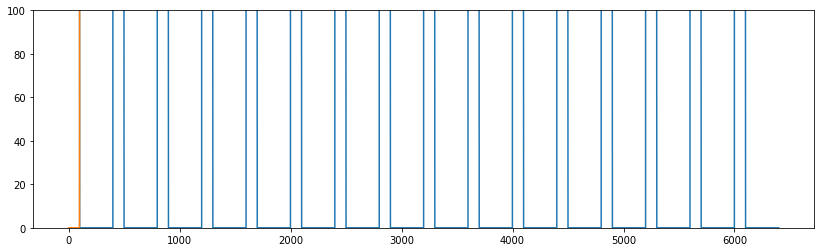

In [9]:
plt.figure(figsize=(14,4))
plt.plot(sim.data[p_paused][fan1_slc]*2000)
plt.plot(meg_from_spikes(sim.data[p_spikes][fan1_slc]));
plt.ylim(0, 100)

In [10]:
fin_enc = neg_voja.encoder_hist[-1].copy()

## Verification

In [11]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc, intercepts=intercepts, seed=seed)
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [12]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

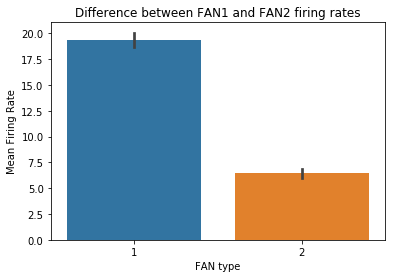

In [13]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

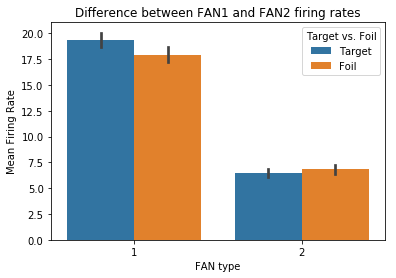

In [14]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)